In [1]:
import os
import time
import datetime

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AlexC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
device = "cuda"
!nvidia-smi

Sun Jan 29 17:53:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.02       Driver Version: 528.02       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   37C    P2    50W / 250W |    583MiB /  8192MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
urls = [f"https://github.com/cluffa/crossfit-workouts/raw/main/data/{year}.csv" for year in range(2001, 2022)]
urls.append("https://github.com/cluffa/crossfit-workouts/raw/main/data/wc.csv")
dfs = [pd.read_csv(url) for url in urls]

In [5]:
df = pd.concat(dfs, ignore_index = True)
df

,id,text,url
0,10210,For time:<|newline|>Fast & Heavy<|newline|>Dum...,https://www.crossfit.com/workout/2001/02/10
1,10211,Dumbbell deadlift 10 reps<|newline|>Hang from ...,https://www.crossfit.com/workout/2001/02/11
2,10212,Today's workout is a simple yet elegant whole ...,https://www.crossfit.com/workout/2001/02/12
3,10213,"1) ""Warm Up"": Bike 20 minutes at a warm-up pac...",https://www.crossfit.com/workout/2001/02/13
4,10214,On Monday we worked gymnastics/calisthenic mov...,https://www.crossfit.com/workout/2001/02/14
...,...,...,...
6284,596,3 rounds for time of:<|newline|>Push Jerks - l...,NaN
6285,597,For time:<|newline|>21 Deadlifts - lb<|newline...,NaN
6286,598,For time:<|newline|>100 Jump Rope (Single)<|ne...,NaN
6287,599,3 rounds for time of:<|newline|>Deadlifts - 22...,NaN


In [6]:
bios = df.text.copy() #just use the main bio text in this example
bios = [bio.replace("<|newline|>", "\n") for bio in bios]

<AxesSubplot: ylabel='Count'>

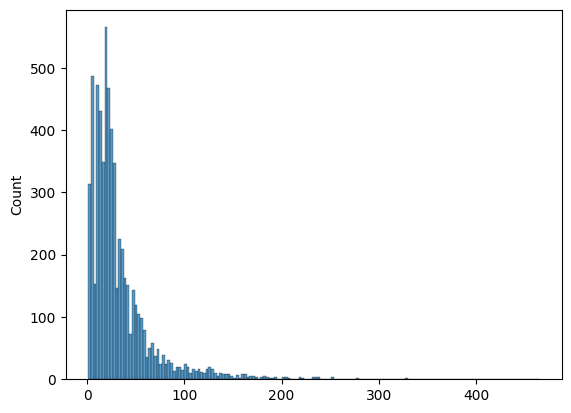

In [7]:
doc_lengths = []

for bio in bios:

    # get rough token count distribution
    tokens = nltk.word_tokenize(bio)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.histplot(doc_lengths)

In [8]:
len(doc_lengths[doc_lengths > 256])/len(doc_lengths)

0.002226109079344888

In [9]:
np.average(doc_lengths)

33.596915248847196

In [10]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [11]:
batch_size = 8

In [12]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=256):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [13]:
dataset = GPT2Dataset(bios, tokenizer, max_length=256)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

5,660 training samples
  629 validation samples


In [14]:
train_dataloader = DataLoader(
    train_dataset,  # The training samples.
    sampler = RandomSampler(train_dataset), # Select batches randomly
    batch_size = batch_size # Trains with this batch size.
)

validation_dataloader = DataLoader(
    val_dataset, # The validation samples.
    sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
    batch_size = batch_size # Evaluate with this batch size.
)

In [15]:
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device(device)
model.to(device)

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [16]:
epochs = 13
learning_rate = 5e-5
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 250

In [17]:
optimizer = AdamW(
    model.parameters(),
    lr = learning_rate,
    eps = epsilon
)

c:\Users\AlexC\workspace\GitFit\.venv\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [18]:
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps = warmup_steps, 
    num_training_steps = total_steps
)

In [19]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [20]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            # model.eval()

            # sample_outputs = model.generate(
            #                         bos_token_id=random.randint(1,30000),
            #                         do_sample=True,   
            #                         top_k=50, 
            #                         max_length = 200,
            #                         top_p=0.95, 
            #                         num_return_sequences=1
            #                     )
            # for i, sample_output in enumerate(sample_outputs):
            #       print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            # model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 13 ========
Training...
  Batch   250  of    708. Loss: 0.6379354596138.   Elapsed: 0:01:19.
  Batch   500  of    708. Loss: 0.8979791402816772.   Elapsed: 0:02:46.

  Average training loss: 1.20
  Training epoch took: 0:03:50

Running Validation...
  Validation Loss: 0.47
  Validation took: 0:00:07

======== Epoch 2 / 13 ========
Training...
  Batch   250  of    708. Loss: 0.22518908977508545.   Elapsed: 0:01:20.
  Batch   500  of    708. Loss: 0.35925257205963135.   Elapsed: 0:02:39.

  Average training loss: 0.47
  Training epoch took: 0:03:46

Running Validation...
  Validation Loss: 0.39
  Validation took: 0:00:08

======== Epoch 3 / 13 ========
Training...
  Batch   250  of    708. Loss: 0.3145039975643158.   Elapsed: 0:01:20.
  Batch   500  of    708. Loss: 0.35382065176963806.   Elapsed: 0:02:40.

  Average training loss: 0.41
  Training epoch took: 0:03:46

Running Validation...
  Validation Loss: 0.37
  Validation took: 0:00:08

======== Epoch 4 / 13 =====

In [21]:
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,1.196452,0.468355,0:03:50,0:00:07
2,0.467160,0.394891,0:03:46,0:00:08
3,0.413066,0.367098,0:03:46,0:00:08
4,0.378494,0.349361,0:03:47,0:00:08
5,0.353170,0.338938,0:03:40,0:00:07
6,0.332878,0.332685,0:03:24,0:00:07
7,0.313823,0.323383,0:03:24,0:00:07
8,0.298851,0.320355,0:03:24,0:00:07
9,0.285380,0.318345,0:03:24,0:00:07


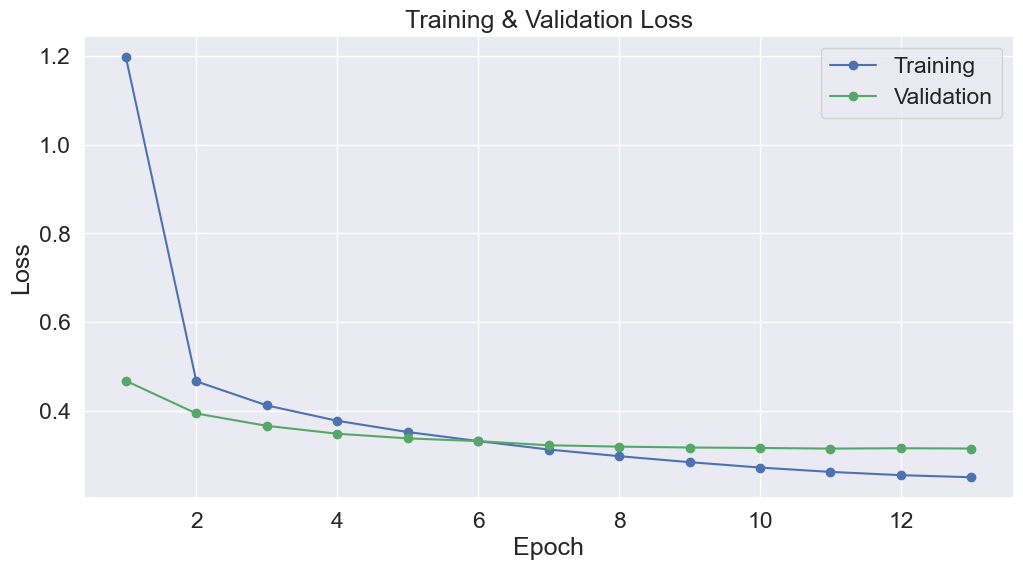

In [22]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
#plt.xticks([1, 2, 3, 4])

plt.show()

In [23]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

In [24]:
output_dir = './gitfit-model/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./gitfit-model/


('./gitfit-model/tokenizer_config.json',
 './gitfit-model/special_tokens_map.json',
 './gitfit-model/vocab.json',
 './gitfit-model/merges.txt',
 './gitfit-model/added_tokens.json')

In [25]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

#print(generated)

sample_outputs = model.generate(
    generated, 
    #bos_token_id=random.randint(1,30000),
    do_sample=True,   
    top_k=50, 
    max_length = 300,
    top_p=0.95, 
    num_return_sequences=10
)

with open("output.txt", "w", encoding="utf-8") as f:
    for i, sample_output in enumerate(sample_outputs):
        outstr = "---- {} ----\n{}\n\n".format(i+1, tokenizer.decode(sample_output, skip_special_tokens=True))
        outstr = outstr.replace("<|newline|>", "\n")
        f.writelines(outstr)
        print(outstr)
        
model.train()

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


---- 1 ----
Complete as many rounds as possible in 12 minutes of:
50 double-unders
60 single-leg squats, alternating
Run 800 meters


---- 2 ----
Run 1 mile
"There are times when friendship is the safest thing to do."
- William James


---- 3 ----
CrossFit Games Open 12.2
Complete as many reps in 20 minutes as you can of:
20 box jumps
20 overhead squats
♀ 24-in. box  ♂ 32-in. box


---- 4 ----
Complete as many rounds as possible in 12 minutes of:
95-lb. overhead squats, 5 reps
Run 400 meters
"You have to be ready for every opportunity, but only when it's right."
- Marcus Aurelius Antoninus


---- 5 ----
Complete as many rounds as possible in 8 minutes of:
10 Pull-ups
20 Push-ups
30 Squats
OR
Complete as many rounds as possible in 8 minutes of:
30 Toes-to-bar
40 Push-ups


---- 6 ----
Run 10K


---- 7 ----
"Barbara"
Five rounds, each for time of:
20 Pull-ups
30 Push-ups
40 Sit-ups
50 Squats


---- 8 ----
"Fran"
Three rounds, 21-15- and 9 reps, for time of:
95 pound Thruster
Pull-ups
"Th

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

In [26]:
output_dir = "./gitfit-model/"
model = GPT2LMHeadModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro